In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy.stats import f_oneway

In [51]:
train = pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [52]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [56]:
train.shape

(1460, 81)

In [57]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [58]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [59]:
train.sort_values("SalePrice")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
495,496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
916,917,20,C (all),50.0,9000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2006,WD,Abnorml,35311
968,969,50,RM,50.0,5925,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,5,2009,WD,Abnorml,37900
533,534,20,RL,50.0,5000,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,39300
30,31,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,40000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


In [60]:
train.sort_values("SalePrice", ascending = False).head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
1046,1047,60,RL,85.0,16056,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,New,Partial,556581
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
769,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000
178,179,20,RL,63.0,17423,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,New,Partial,501837
798,799,60,RL,104.0,13518,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,New,Partial,485000


In [256]:
#Remove columns with high proportion of missing values.
train_nulls = train.isnull().sum()
train_nulls

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64

In [257]:
#Remove records with missing values.
train_nan = train.isna().sum().sort_values(axis = 0)
train_nan

MSSubClass       0
GarageType       0
FireplaceQu      0
Fireplaces       0
Functional       0
                ..
Exterior2nd      0
Exterior1st      0
RoofMatl         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64

In [258]:
del train['PoolQC']

In [259]:
del train['MiscFeature']

In [260]:
del train['Alley']

In [261]:
del train['Fence']

In [262]:
del train['FireplaceQu']

In [263]:
train.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,320,0,0,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,307000
7,60,RL,0.0,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,228,0,0,0,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,1,2008,WD,Normal,118000


In [264]:
train_nan = train.isna().sum().sort_values(axis = 0)
train_nan

MSSubClass      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
               ..
Exterior2nd     0
Exterior1st     0
RoofMatl        0
YearRemodAdd    0
SalePrice       0
Length: 75, dtype: int64

In [265]:
del train['LotFrontage']

In [266]:
train = train.sort_values(by='SalePrice', ascending=False)
train.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,60,RL,21535,Pave,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,...,0,0,0,0,0,1,2007,WD,Normal,755000
1182,60,RL,15623,Pave,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,...,0,0,0,555,0,7,2007,WD,Abnorml,745000
1169,60,RL,35760,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,...,0,0,0,0,0,7,2006,WD,Normal,625000
898,20,RL,12919,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,...,0,0,0,0,0,3,2010,New,Partial,611657
803,60,RL,13891,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,0,0,192,0,0,1,2009,New,Partial,582933


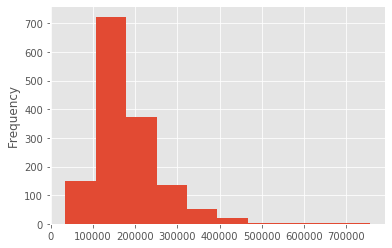

In [268]:
train['SalePrice'].plot.hist();

In [269]:
#checking data distribution.
def normalidad_variable_numerica(col):
    stats.probplot(train[col], plot=plt)
    plt.xlabel('Diagrama de Probabilidad(normal) de la variable {}'.format(col))
    plt.show()

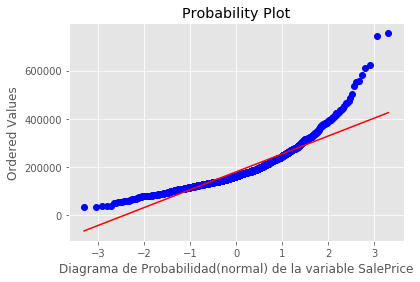

In [270]:
normalidad_variable_numerica('SalePrice')

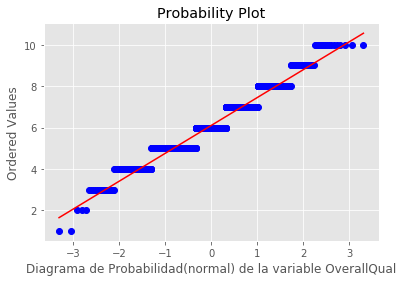

In [271]:
normalidad_variable_numerica('OverallQual')

ValueError: num must be 1 <= num <= 30, not 31

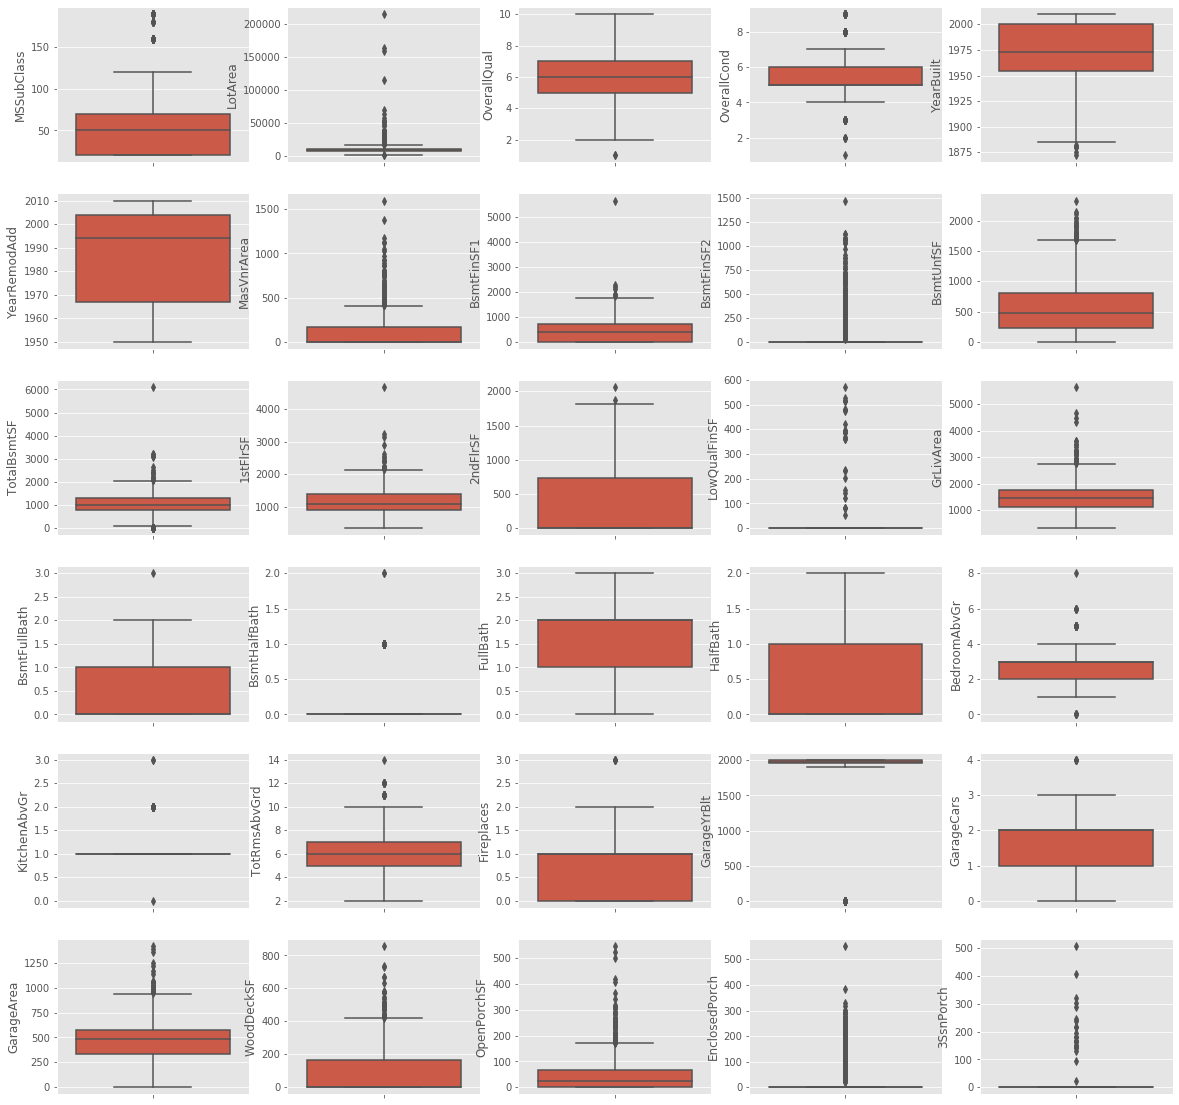

In [274]:
# create boxplots to take a look at outliers
train_lst = train.select_dtypes(exclude=['object']).copy()
fig = plt.figure(figsize=(20,20))
for index,col in enumerate(train_lst.columns):
    plt.subplot(6,5,index+1)
    sns.boxplot(y=col, data=train_lst)
fig.tight_layout(pad=1.5)

In [ ]:
columnas_numericas = train.select_dtypes(['int', 'float']).columns
for num_col in columnas_numericas:
    _, pval = stats.normaltest(train[num_col])
    if(pval < 0.05):
        print("Columna {} no sigue una distribución normal".format(num_col))

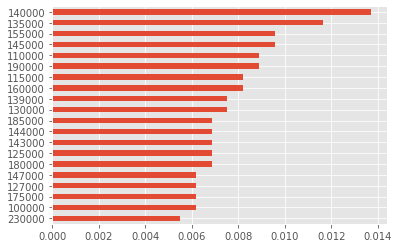

In [276]:
def distribucion_variable_categorica(col):
    train[col].value_counts(ascending=True,normalize=True).tail(20).plot.barh()
    plt.show()
distribucion_variable_categorica('SalePrice')

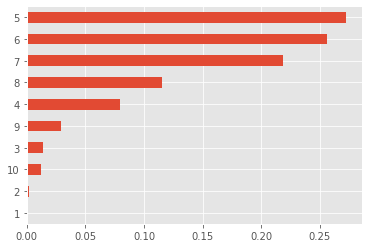

In [277]:
distribucion_variable_categorica('OverallQual')

In [278]:
#Feature reduction.
train.var ()

MSSubClass       1.789338e+03
LotArea          9.962565e+07
OverallQual      1.912679e+00
OverallCond      1.238322e+00
YearBuilt        9.122154e+02
YearRemodAdd     4.262328e+02
MasVnrArea       3.266383e+04
BsmtFinSF1       2.080255e+05
BsmtFinSF2       2.602391e+04
BsmtUnfSF        1.952464e+05
TotalBsmtSF      1.924624e+05
1stFlrSF         1.494501e+05
2ndFlrSF         1.905571e+05
LowQualFinSF     2.364204e+03
GrLivArea        2.761296e+05
BsmtFullBath     2.692682e-01
BsmtHalfBath     5.700283e-02
FullBath         3.035082e-01
HalfBath         2.528937e-01
BedroomAbvGr     6.654938e-01
KitchenAbvGr     4.854892e-02
TotRmsAbvGrd     2.641903e+00
Fireplaces       4.155947e-01
GarageYrBlt      2.058412e+05
GarageCars       5.584797e-01
GarageArea       4.571251e+04
WoodDeckSF       1.570981e+04
OpenPorchSF      4.389861e+03
EnclosedPorch    3.735550e+03
3SsnPorch        8.595059e+02
ScreenPorch      3.108889e+03
PoolArea         1.614216e+03
MiscVal          2.461381e+05
MoSold    

In [279]:
train_numeric_col = []
for c in train.columns:
    t = str(train[c].dtype)
    if "int" in t or "float" in t:
        train_numeric_col.append(c)
train_numeric_col

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [280]:
train_std = train.std()
train_std

MSSubClass          42.300571
LotArea           9981.264932
OverallQual          1.382997
OverallCond          1.112799
YearBuilt           30.202904
YearRemodAdd        20.645407
MasVnrArea         180.731373
BsmtFinSF1         456.098091
BsmtFinSF2         161.319273
BsmtUnfSF          441.866955
TotalBsmtSF        438.705324
1stFlrSF           386.587738
2ndFlrSF           436.528436
LowQualFinSF        48.623081
GrLivArea          525.480383
BsmtFullBath         0.518911
BsmtHalfBath         0.238753
FullBath             0.550916
HalfBath             0.502885
BedroomAbvGr         0.815778
KitchenAbvGr         0.220338
TotRmsAbvGrd         1.625393
Fireplaces           0.644666
GarageYrBlt        453.697295
GarageCars           0.747315
GarageArea         213.804841
WoodDeckSF         125.338794
OpenPorchSF         66.256028
EnclosedPorch       61.119149
3SsnPorch           29.317331
ScreenPorch         55.757415
PoolArea            40.177307
MiscVal            496.123024
MoSold    

In [169]:
#promedio de precio de venta
saleprice_mean = train['SalePrice'].mean()
saleprice_mean

180921.19589041095

In [170]:
#precio máximo de venta
max_saleprice = train['SalePrice'].max()
max_saleprice

755000

In [171]:
#precio mínimo de venta
min_saleprice = train['SalePrice'].min()
min_saleprice

34900

In [172]:
mayor_saleprice = train[train.SalePrice >= 180921.19589041095]
mayor_saleprice.sort_values(by='SalePrice', ascending=False).head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,60,RL,104.0,21535,Pave,0,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,1,2007,WD,Normal,755000
1182,60,RL,160.0,15623,Pave,0,IR1,Lvl,AllPub,Corner,...,555,Ex,MnPrv,0,0,7,2007,WD,Abnorml,745000
1169,60,RL,118.0,35760,Pave,0,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,0,7,2006,WD,Normal,625000
898,20,RL,100.0,12919,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,3,2010,New,Partial,611657
803,60,RL,107.0,13891,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,1,2009,New,Partial,582933
1046,60,RL,85.0,16056,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,7,2006,New,Partial,556581
440,20,RL,105.0,15431,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,4,2009,WD,Normal,555000
769,60,RL,47.0,53504,Pave,0,IR2,HLS,AllPub,CulDSac,...,0,0,0,0,0,6,2010,WD,Normal,538000
178,20,RL,63.0,17423,Pave,0,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,0,7,2009,New,Partial,501837
798,60,RL,104.0,13518,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,7,2009,New,Partial,485000


In [173]:
minor_saleprice = train[train.SalePrice <= 180921.19589041095]
minor_saleprice.sort_values(by='SalePrice', ascending=False).tail(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
812,20,C (all),66.0,8712,Grvl,0,Reg,Bnk,AllPub,Inside,...,0,0,0,Shed,54,6,2010,WD,Alloca,55993
1325,30,RM,40.0,3636,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,MnPrv,0,0,1,2008,WD,Normal,55000
705,190,RM,70.0,5600,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,Othr,3500,7,2010,WD,Normal,55000
1337,30,RM,153.0,4118,Pave,Grvl,IR1,Bnk,AllPub,Corner,...,0,0,0,0,0,3,2006,WD,Normal,52500
710,30,RL,56.0,4130,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,7,2008,WD,Normal,52000
30,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,MnPrv,0,0,7,2008,WD,Normal,40000
533,20,RL,50.0,5000,Pave,0,Reg,Low,AllPub,Inside,...,0,0,0,0,0,1,2007,WD,Normal,39300
968,50,RM,50.0,5925,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,GdWo,0,0,5,2009,WD,Abnorml,37900
916,20,C (all),50.0,9000,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,10,2006,WD,Abnorml,35311
495,30,C (all),60.0,7879,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,GdWo,0,0,11,2009,WD,Abnorml,34900


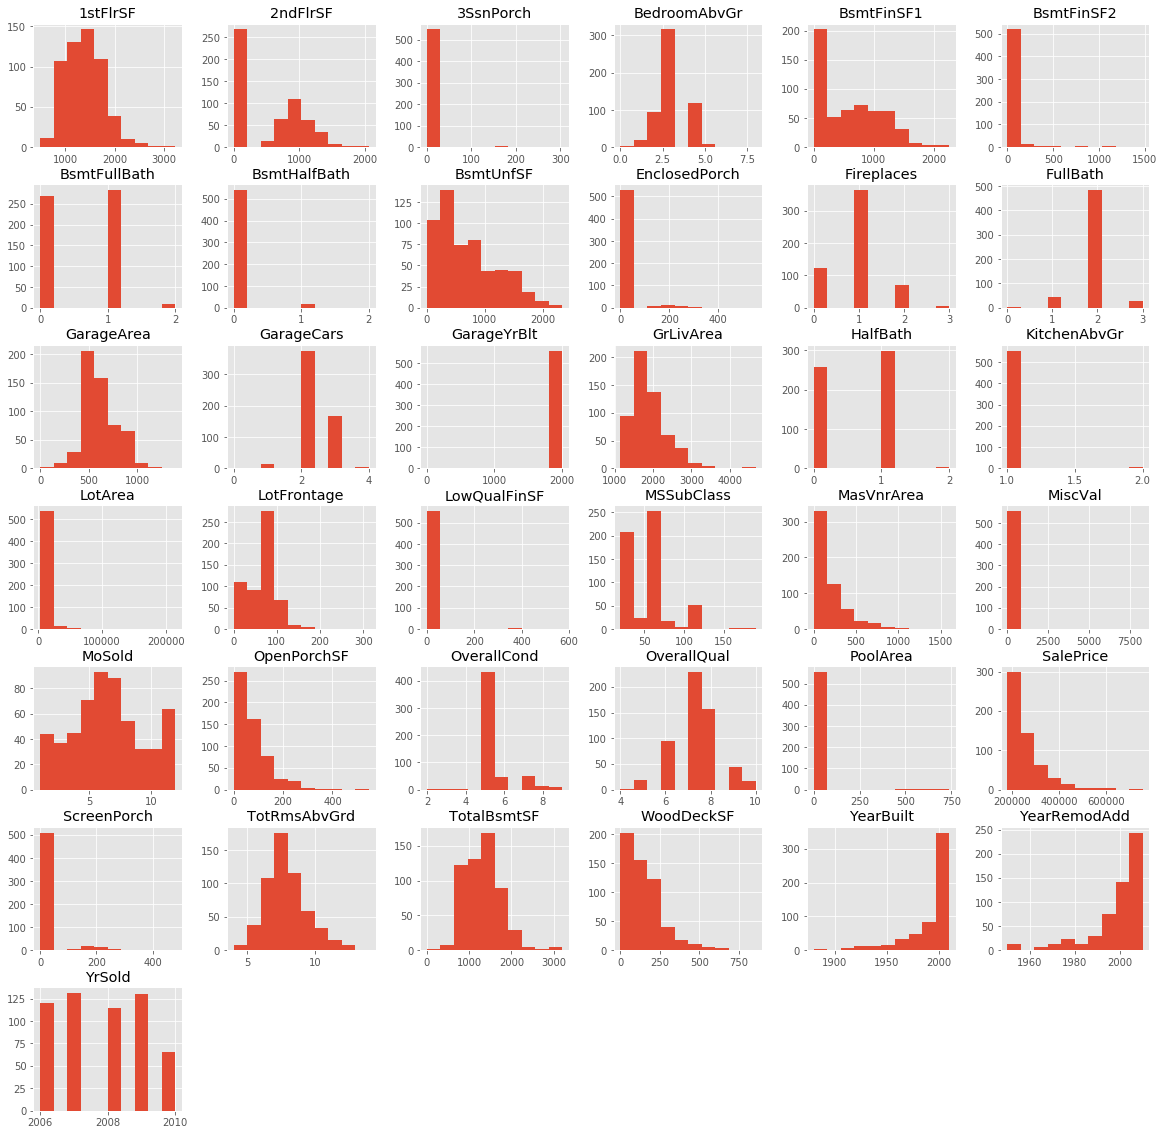

In [252]:
plt.style.use("ggplot")
mayor_saleprice.hist(figsize=(20,20))
plt.show()

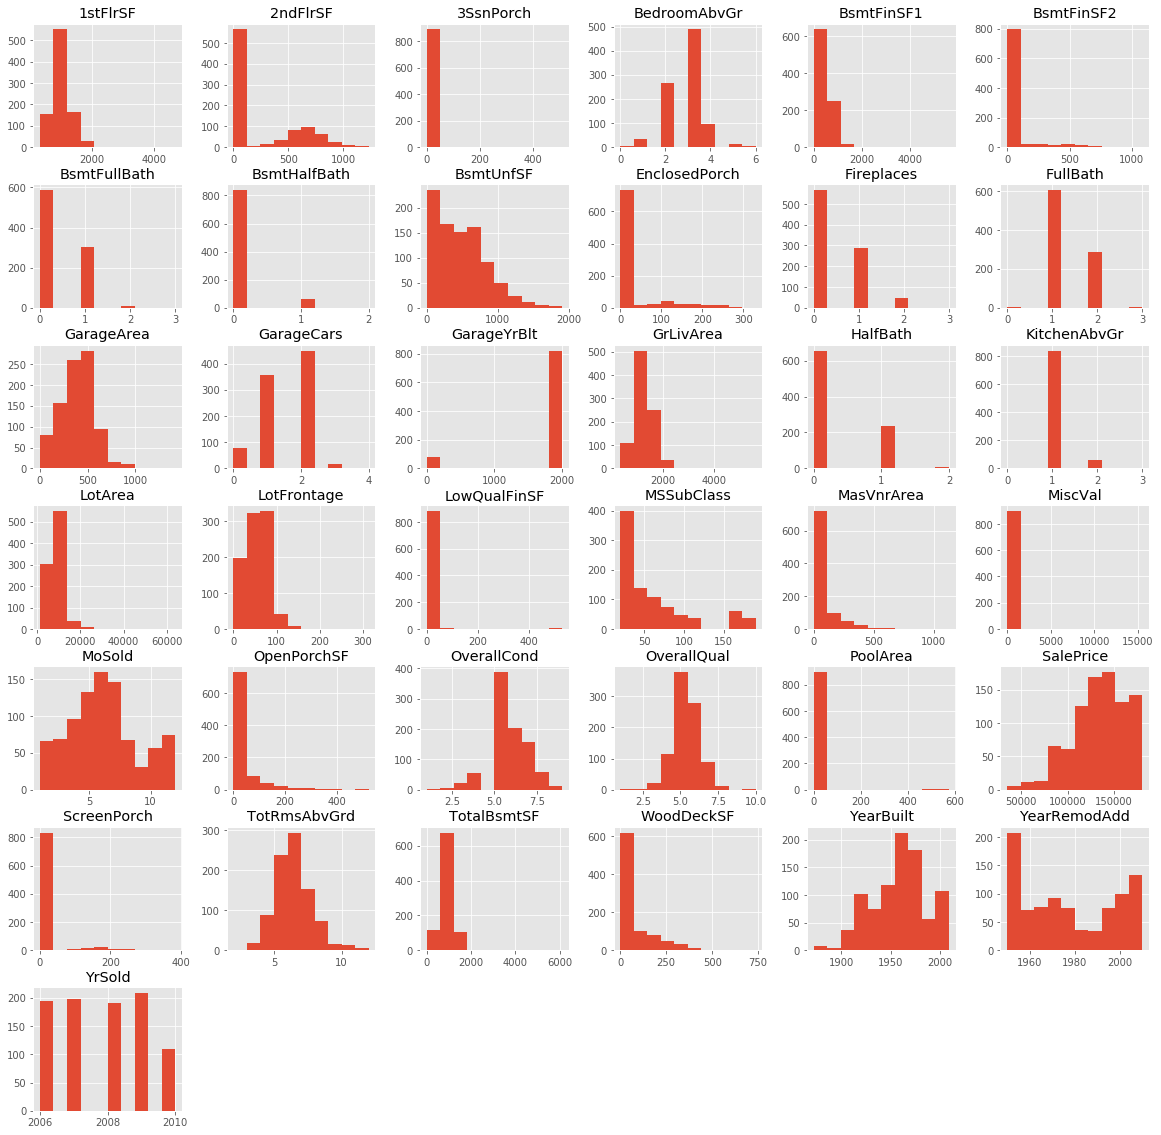

In [253]:
plt.style.use("ggplot")
minor_saleprice.hist(figsize=(20,20))
plt.show()

In [283]:
#observando la correlación de df
corr_train = train.corr()
corr_train

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,-0.140759,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotArea,-0.139781,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,0.111170,-0.002618,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,-0.059119,0.308159,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,0.040229,-0.136841,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,-0.049107,0.149040,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,-0.067759,0.181133,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.023573,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,-0.071330,0.113862,...,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317,0.472614
BsmtFinSF1,-0.069836,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,-0.050117,-0.495251,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.071330,-0.050117,1.000000,-0.209294,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378
BsmtUnfSF,-0.140759,-0.002618,0.308159,-0.136841,0.149040,0.181133,0.113862,-0.495251,-0.209294,1.000000,...,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,-0.023837,0.034888,-0.041258,0.214479


In [284]:
train_spearman = train.corr(method='spearman')
train_spearman

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.269570,0.108065,-0.071770,0.035848,0.006802,0.025821,-0.107629,-0.083871,-0.117603,...,0.023370,0.031900,0.011023,-0.035830,-0.021673,0.033250,-0.032840,0.018403,-0.027401,0.007192
LotArea,-0.269570,1.000000,0.233303,-0.046912,0.103385,0.075158,0.175909,0.171995,0.072019,0.077830,...,0.184285,0.176965,-0.066563,0.062282,0.092316,0.084460,0.059297,0.006423,-0.027473,0.456461
OverallQual,0.108065,0.233303,1.000000,-0.177521,0.647392,0.557723,0.408136,0.132957,-0.117560,0.272939,...,0.259439,0.435046,-0.162434,0.032903,0.046335,0.056667,-0.088019,0.061455,-0.025464,0.809829
OverallCond,-0.071770,-0.046912,-0.177521,1.000000,-0.416964,-0.041464,-0.175895,-0.011087,0.102471,-0.128270,...,-0.042662,-0.133284,0.109749,0.032384,0.074728,-0.005605,0.086625,-0.007203,0.050214,-0.129325
YearBuilt,0.035848,0.103385,0.647392,-0.416964,1.000000,0.684388,0.395589,0.189645,-0.111692,0.139014,...,0.287729,0.392691,-0.408622,0.022498,-0.073119,0.008986,-0.091786,0.018621,-0.014100,0.652682
YearRemodAdd,0.006802,0.075158,0.557723,-0.041464,0.684388,1.000000,0.229194,0.063353,-0.126086,0.176921,...,0.230241,0.353325,-0.235037,0.051694,-0.045808,0.002821,-0.090868,0.021081,0.045158,0.571159
MasVnrArea,0.025821,0.175909,0.408136,-0.175895,0.395589,0.229194,1.000000,0.237541,-0.059622,0.074779,...,0.174173,0.204573,-0.178764,0.041525,0.039308,0.005148,-0.049343,0.016964,0.000322,0.415906
BsmtFinSF1,-0.107629,0.171995,0.132957,-0.011087,0.189645,0.063353,0.237541,1.000000,0.050398,-0.573638,...,0.179359,0.081420,-0.148339,0.046802,0.071989,0.057586,0.005097,-0.016405,0.020793,0.301871
BsmtFinSF2,-0.083871,0.072019,-0.117560,0.102471,-0.111692,-0.126086,-0.059622,0.050398,1.000000,-0.271007,...,0.069343,-0.068991,0.041524,-0.016079,0.058716,0.068076,0.030363,-0.025808,0.026054,-0.038806
BsmtUnfSF,-0.117603,0.077830,0.272939,-0.128270,0.139014,0.176921,0.074779,-0.573638,-0.271007,1.000000,...,-0.034866,0.156127,0.044242,0.013418,-0.012447,-0.036809,-0.044460,0.037116,-0.038552,0.185197


In [290]:
corr_saleprice = corr_train["SalePrice"].sort_values(ascending=False)
corr_saleprice

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
GarageYrBlt      0.261366
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [292]:
# OverallQual, GrLivArea, GarageArea, TotalBsmtSF y 1stFlrSF, tienen una correlación positiva con respecto a la SalePrice,
#por lo que se puede investigar a fondo si esatas variables influyen en el aumento del precio de un edificio/casa.

#KitchenAbvGr, EnclosedPorch, MSSubClass, OverallCond tienen una correlación negativa muy significativa,
#por lo que podrían descartarse automaticamente como elementos que produzcan un aumento del precio.

In [293]:
train_pearson = train.corr('pearson')
train_pearson

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,-0.140759,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotArea,-0.139781,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,0.111170,-0.002618,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,-0.059119,0.308159,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,0.040229,-0.136841,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,-0.049107,0.149040,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,-0.067759,0.181133,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.023573,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,-0.071330,0.113862,...,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317,0.472614
BsmtFinSF1,-0.069836,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,-0.050117,-0.495251,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.071330,-0.050117,1.000000,-0.209294,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378
BsmtUnfSF,-0.140759,-0.002618,0.308159,-0.136841,0.149040,0.181133,0.113862,-0.495251,-0.209294,1.000000,...,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,-0.023837,0.034888,-0.041258,0.214479


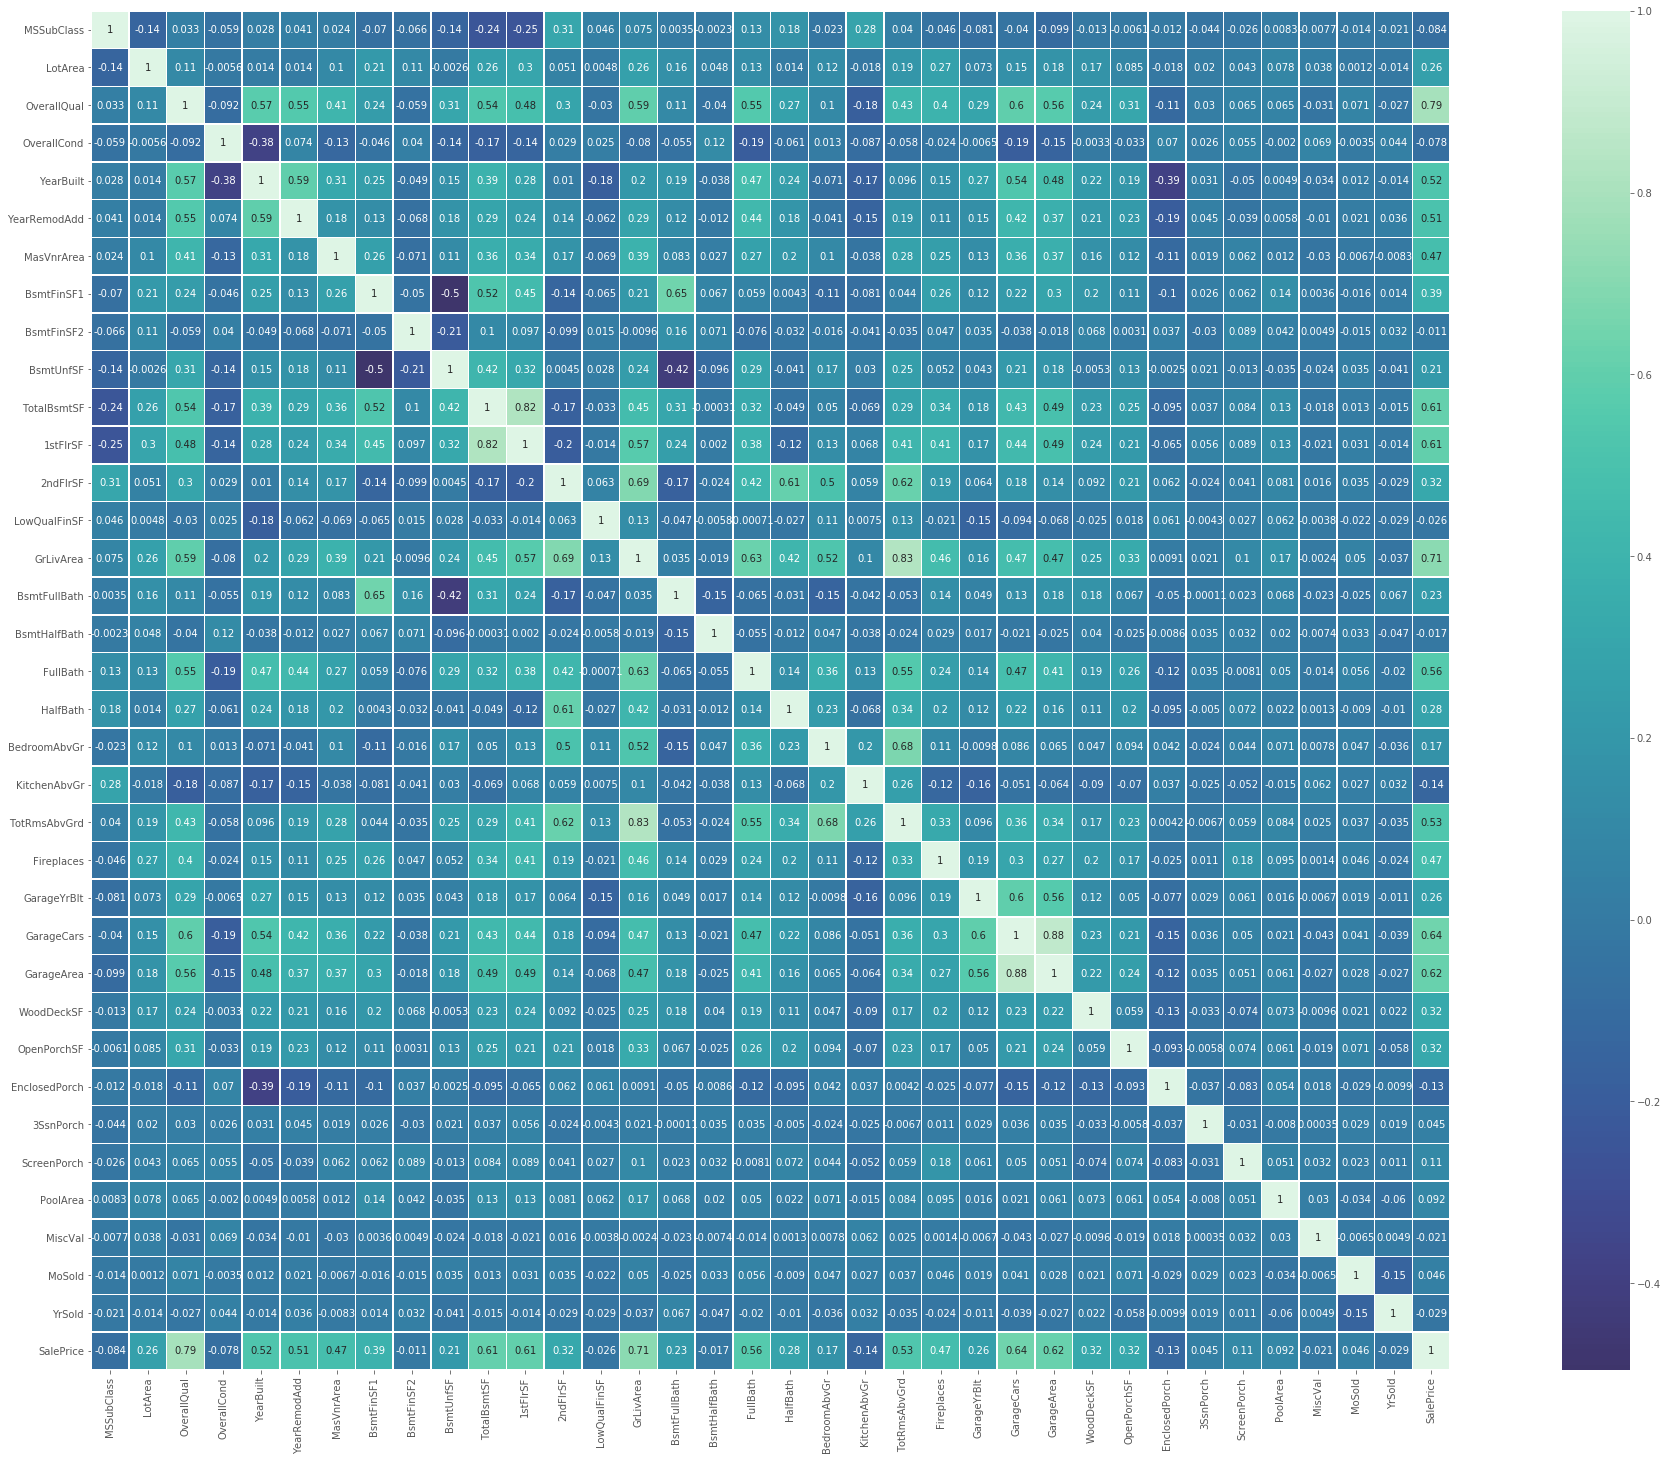

In [295]:
f, ax = plt.subplots(figsize=(40, 25))
sns.heatmap(train_pearson, cmap="mako", vmax=1, center=0, annot = True,
            square=True, linewidths=.5)
plt.show()

In [296]:
saleprice_overallqual = pd.crosstab(index=train["SalePrice"],
                           columns=train["OverallQual"])
saleprice_overallqual

OverallQual,1,2,3,4,5,6,7,8,9,10
SalePrice,,,,,,,,,,
34900,0,0,0,1,0,0,0,0,0,0
35311,0,1,0,0,0,0,0,0,0,0
37900,0,0,1,0,0,0,0,0,0,0
39300,1,0,0,0,0,0,0,0,0,0
40000,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
582933,0,0,0,0,0,0,0,0,1,0
611657,0,0,0,0,0,0,0,0,1,0
625000,0,0,0,0,0,0,0,0,0,1


In [297]:
saleprice_grlivarea = pd.crosstab(index=train["SalePrice"],
                           columns=train["GrLivArea"])
saleprice_grlivarea

GrLivArea,334,438,480,520,605,616,630,672,691,693,...,3279,3395,3447,3493,3608,3627,4316,4476,4676,5642
SalePrice,,,,,,,,,,,,,,,,,,,,,
34900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35311,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39300,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
611657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
625000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [298]:
saleprice_garagecars = pd.crosstab(index=train["SalePrice"],
                           columns=train["GarageCars"])
saleprice_garagecars

GarageCars,0,1,2,3,4
SalePrice,,,,,
34900,1,0,0,0,0
35311,0,1,0,0,0
37900,1,0,0,0,0
39300,1,0,0,0,0
40000,0,1,0,0,0
...,...,...,...,...,...
582933,0,0,0,1,0
611657,0,0,0,1,0
625000,0,0,0,1,0


In [299]:
train["SalePrice"].corr(train["OverallQual"])

0.7909816005838082

In [300]:
train["SalePrice"].corr(train["GrLivArea"])

0.7086244776126521

In [301]:
train["SalePrice"].corr(train["GarageCars"])

0.640409197258351

In [302]:
train_cat_var = []

for i in train.columns:
    if train[i].dtypes == 'object':
        train_cat_var.append(i)

In [303]:
train_cat_var

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [318]:
np.shape(train_cat_var)

(38,)

In [304]:
train_continuos_var = []

for i in train.columns:
    if train[i].dtypes != 'object':
        train_continuos_var.append( i)

In [305]:
train_continuos_var

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [306]:
np.shape(train_continuos_var)

(36,)

In [307]:
train_nulls = train.isnull().sum()
train_nulls

MSSubClass       0
MSZoning         0
LotArea          0
Street           0
LotShape         0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 74, dtype: int64

In [308]:
#standardizes the data by removing the mean and scaling the data so that its variance is equal to 1
std = StandardScaler()
train_features = train.copy()
train_stand = train_features[train_continuos_var]
train_stand = std.fit_transform(train_stand)

In [309]:
#Convert categorical data to numerical.
train_numerical = train.copy()
train_cat_onehot = pd.get_dummies(train_numerical, drop_first = True, columns = train_cat_var)
train_cat_onehot

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
691,60,21535,10,6,1994,1995,1170.0,1455,0,989,...,0,0,0,0,1,0,0,0,1,0
1182,60,15623,10,5,1996,1996,0.0,2096,0,300,...,0,0,0,0,1,0,0,0,0,0
1169,60,35760,10,5,1995,1996,1378.0,1387,0,543,...,0,0,0,0,1,0,0,0,1,0
898,20,12919,9,5,2009,2010,760.0,2188,0,142,...,0,0,1,0,0,0,0,0,0,1
803,60,13891,9,5,2008,2009,424.0,0,0,1734,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,70,8500,4,4,1920,1950,0.0,0,0,649,...,0,0,0,0,1,0,0,0,1,0
533,20,5000,1,3,1946,1950,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
968,50,5925,3,6,1910,1950,0.0,0,0,600,...,0,0,0,0,1,0,0,0,0,0
916,20,9000,2,3,1949,1950,0.0,50,0,430,...,0,0,0,0,1,0,0,0,0,0


In [319]:
#Compute field relationship scores with the chosen statistical model
X = sm.add_constant(train.SalePrice)
Y = train.OverallQual

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            OverallQual   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     2437.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          2.19e-313
Time:                        23:10:18   Log-Likelihood:                -1827.3
No. Observations:                1460   AIC:                             3659.
Df Residuals:                    1458   BIC:                             3669.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6080      0.055     65.462      0.0

In [332]:
model.params

const       -91.408637
SalePrice     0.001075
dtype: float64

In [351]:
sm.stats.linear_rainbow(model)

(0.9712007421919525, 0.6533542264356029)

In [336]:
X = sm.add_constant(train.SalePrice)
Y = train.GrLivArea

model1 = sm.OLS(Y, X).fit()
predictions = model1.predict(X) 

print_model1 = model1.summary()
print(print_model1)

                            OLS Regression Results                            
Dep. Variable:              GrLivArea   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     1471.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          4.52e-223
Time:                        23:27:15   Log-Likelihood:                -10708.
No. Observations:                1460   AIC:                         2.142e+04
Df Residuals:                    1458   BIC:                         2.143e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        667.4377     24.150     27.637      0.0

In [337]:
model1.params

const        667.437656
SalePrice      0.004687
dtype: float64

In [353]:
sm.stats.linear_rainbow(model1)

(0.9712007421919525, 0.6533542264356029)

In [338]:
X = sm.add_constant(train.SalePrice)
Y = train.GarageCars

model2 = sm.OLS(Y, X).fit()
predictions = model2.predict(X) 

print_model2 = model2.summary()
print(print_model2)

                            OLS Regression Results                            
Dep. Variable:             GarageCars   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     1014.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          2.50e-169
Time:                        23:27:48   Log-Likelihood:                -1260.6
No. Observations:                1460   AIC:                             2525.
Df Residuals:                    1458   BIC:                             2536.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6772      0.037     18.114      0.0

In [339]:
model2.params

const        0.677195
SalePrice    0.000006
dtype: float64

In [354]:
sm.stats.linear_rainbow(model2)

(1.6810765448523295, 1.5813133503297878e-12)

In [340]:
X = sm.add_constant(train.SalePrice)
Y = train.LotArea

model3 = sm.OLS(Y, X).fit()
predictions = model3.predict(X) 

print_model3 = model3.summary()
print(print_model3)

                            OLS Regression Results                            
Dep. Variable:                LotArea   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     109.1
Date:                Wed, 27 Jan 2021   Prob (F-statistic):           1.12e-24
Time:                        23:28:22   Log-Likelihood:                -15463.
No. Observations:                1460   AIC:                         3.093e+04
Df Residuals:                    1458   BIC:                         3.094e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4519.3555    627.100      7.207      0.0

In [341]:
model3.params

const        4519.355469
SalePrice       0.033150
dtype: float64

In [355]:
sm.stats.linear_rainbow(model3)

(6.1764329821859825, 1.2906214682632746e-118)

In [342]:
X = sm.add_constant(train.SalePrice)
Y = train.YearBuilt

model4 = sm.OLS(Y, X).fit()
predictions = model4.predict(X) 

print_model4 = model4.summary()
print(print_model4)

                            OLS Regression Results                            
Dep. Variable:              YearBuilt   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     548.7
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          2.99e-103
Time:                        23:29:08   Log-Likelihood:                -6813.6
No. Observations:                1460   AIC:                         1.363e+04
Df Residuals:                    1458   BIC:                         1.364e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1935.3010      1.677   1154.089      0.0

In [343]:
model4.params

const        1935.301020
SalePrice       0.000199
dtype: float64

In [356]:
sm.stats.linear_rainbow(model4)

(1.3116218733365987, 0.0001286088712052051)

In [344]:
X = sm.add_constant(train.SalePrice)
Y = train['1stFlrSF']

model5 = sm.OLS(Y, X).fit()
predictions = model5.predict(X) 

print_model5 = model5.summary()
print(print_model5)

                            OLS Regression Results                            
Dep. Variable:               1stFlrSF   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     845.5
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          5.39e-147
Time:                        23:29:30   Log-Likelihood:                -10435.
No. Observations:                1460   AIC:                         2.087e+04
Df Residuals:                    1458   BIC:                         2.088e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        629.2288     20.033     31.409      0.0

In [345]:
model5.params

const        629.228833
SalePrice      0.002948
dtype: float64

In [357]:
sm.stats.linear_rainbow(model5)

(0.7868010111121553, 0.9993859325206528)

In [346]:
X = sm.add_constant(train.SalePrice)
Y = train['YearRemodAdd']

model6 = sm.OLS(Y, X).fit()
predictions = model6.predict(X) 

print_model6 = model6.summary()
print(print_model6)     

                            OLS Regression Results                            
Dep. Variable:           YearRemodAdd   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     504.7
Date:                Wed, 27 Jan 2021   Prob (F-statistic):           3.16e-96
Time:                        23:30:06   Log-Likelihood:                -6274.3
No. Observations:                1460   AIC:                         1.255e+04
Df Residuals:                    1458   BIC:                         1.256e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1961.0231      1.159   1691.959      0.0

In [347]:
model6.params

const        1961.023109
SalePrice       0.000132
dtype: float64

In [358]:
sm.stats.linear_rainbow(model6)

(1.054309527153481, 0.23772723289071004)

In [348]:
X = sm.add_constant(train.SalePrice)
Y = train['MasVnrArea']

model7 = sm.OLS(Y, X).fit()
predictions = model7.predict(X) 

print_model7 = model7.summary()
print(print_model7)            

                            OLS Regression Results                            
Dep. Variable:             MasVnrArea   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     419.3
Date:                Wed, 27 Jan 2021   Prob (F-statistic):           4.10e-82
Time:                        23:30:33   Log-Likelihood:                -9474.3
No. Observations:                1460   AIC:                         1.895e+04
Df Residuals:                    1458   BIC:                         1.896e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -91.4086     10.374     -8.811      0.0

In [349]:
model7.params

const       -91.408637
SalePrice     0.001075
dtype: float64

In [359]:
sm.stats.linear_rainbow(model7)

(1.4589061260078064, 1.872038612196103e-07)